Introduction:
 
Football depends on an equal playing field. One of Football’s captivating factors is the balance of strength with decision-making; if the focus of football shifted away from the actual game and pivoted to exploiting advantages, the sport would lose its core. The National Football League (NFL) has a responsibility to organize a standard among both teams to ensure that, especially in the 21st century, the focus of the sport remains on football and not technology. 

By controlling for differences that could produce unfair advantages, the focus for each team turns inward; statistics provide utilitarian team-diagnostics which can identify key strengths and weaknesses that maximize touchdowns and wins. The relationship between statistics and football embraces the core values of the sport because significant metrics can be used to create significant plays.

The following report analyzes NFL data from 1950-2017 in order to see the varying effects of rushing and passing offenses, defense and special teams in an attempt to identify relevant trends and predict the impact of various features that influence a teams probability of winning. We hypothesize the following: that having a stronger passing attack (more passing yards and touchdowns) gives teams a higher predicted win percentage than teams with a stronger rushing attack(more rushing yards and touchdowns) likely to the effiency in moving the ball through the air as opposed to moving it by rushing. We also hypothesize that defensive features such as interceptions will be indicative predictors of a team's likelihood of winning slightly more than special teams plays, while special teams plays such as field goals made and retun touch downs will also be beneficial predictors of success. Throughout this play-by-play analysis we display our findings about the effects of passing, rushing, defensive and special teams' statistics on win percentages for an individual team through multiple techniques including logit predictions with marginal effects and test and train sets.

In [3]:
# import libraries 
import json
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

In [15]:
# Read JSON file with NFL Data
with open("Downloads/moneyball.json","r") as json_file:  
    data = json.load(json_file)

# create dataframe of NFL data
df = pd.DataFrame(data)
df.head()

,age,date,defense_interception_touchdowns,defense_interception_yards,defense_interceptions,defense_sacks,defense_safeties,defense_tackle_assists,defense_tackles,field_goal_attempts,...,punting_yards,receiving_receptions,receiving_targets,receiving_touchdowns,receiving_yards,rushing_attempts,rushing_touchdowns,rushing_yards,team,year
0,23-120,1990-09-09,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,SEA,1990
1,23-127,1990-09-16,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,SEA,1990
2,23-134,1990-09-23,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,SEA,1990
3,23-142,1990-10-01,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,SEA,1990
4,23-148,1990-10-07,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,SEA,1990


In [37]:
# Group Data
PassPerYear = df.groupby(['year','team','game_number']).agg({'passing_attempts':'sum', 'passing_completions':'sum','passing_yards':'sum','passing_touchdowns':'sum'})
TeamGamesWon = df.groupby(['year','team','game_number']).agg({'game_won':'sum'})
TeamGamesWon['game_won'] = TeamGamesWon['game_won'].apply(lambda x: True if x > 0 else False)
RushPerYear = df.groupby(['year','team','game_number']).agg({'rushing_attempts':'sum', 'rushing_yards':'sum','rushing_touchdowns':'sum'})
DefensePerYear = df.groupby(['year','team','game_number']).agg({'defense_sacks':'sum', 'defense_tackles':'sum','defense_interceptions':'sum'})
SpecialTeamsPerYear = df.groupby(['year','team','game_number']).agg({'kick_return_touchdowns':'sum', 'punt_return_touchdowns':'sum','field_goal_makes':'sum'})
PassPerYear.head(10)


passing_attempts  passing_completions  passing_yards  \
year team game_number                                                         
1950 BAL  1                          22                   42            267   
          10                         18                   42            222   
          11                         22                   41            224   
          12                         18                   43            250   
          2                          13                   28            156   
          3                          13                   28            143   
          4                           4                   21            160   
          5                          16                   39            299   
          6                          22                   45            271   
          7                          14                   31            277   

                       passing_touchdowns  
year team game_number                      
1950 BAL  1                             0  
          10                            2  
          11                            3  
          12                            0  
          2                             0  
          3                             0  
          4                             2  
          5                             3  
          6                             1  
          7                             1

In [17]:
# merge dataframes
WinsWithPassStats = pd.concat([PassPerYear,TeamGamesWon['game_won']],axis = 1).reset_index()
WinsWithRushStats = pd.concat([RushPerYear,TeamGamesWon['game_won']],axis = 1).reset_index()
WinsWithDefense = pd.concat([DefensePerYear,TeamGamesWon['game_won']],axis = 1).reset_index()
WinsWithSpecialTeams = pd.concat([SpecialTeamsPerYear,TeamGamesWon['game_won']],axis = 1).reset_index()

#display all columns in dataframes
pd.set_option('display.max_columns', None)

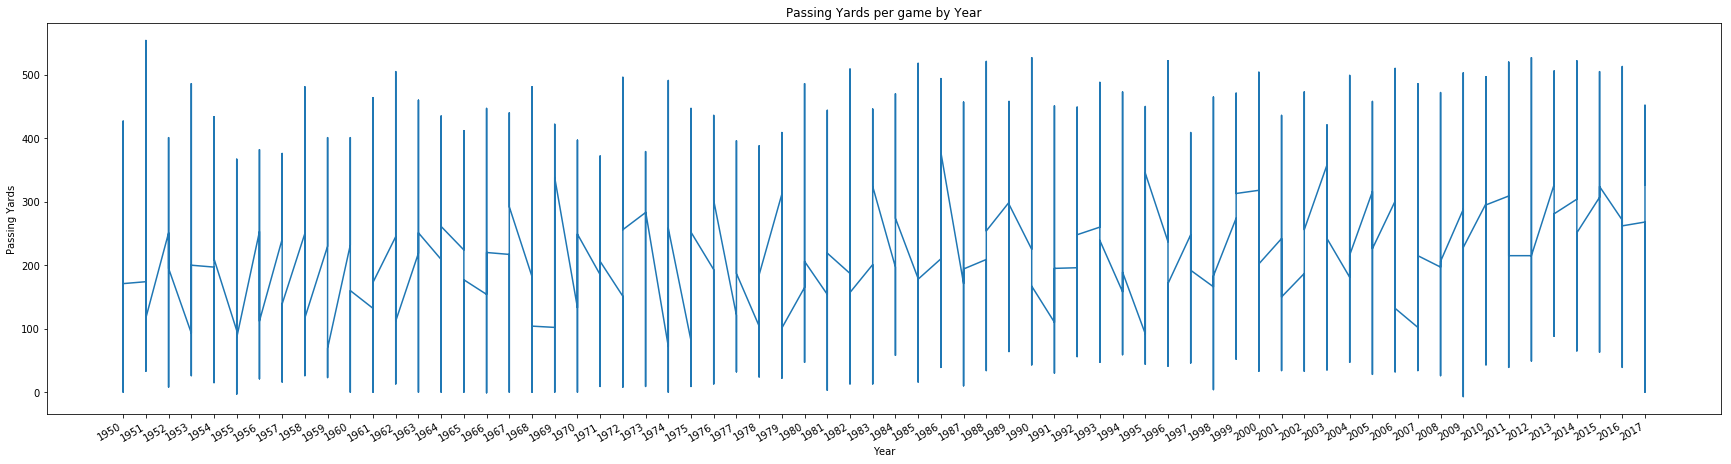

In [42]:
# Over TIME Trends
plt.plot(WinsWithPassStats['year'],WinsWithPassStats['passing_yards'])
plt.xlabel("Year")
plt.ylabel("Passing Yards")
plt.title("Passing Yards per game by Year")
plt.gcf().autofmt_xdate()
plt.rcParams["figure.figsize"] = (30, 8)
plt.show()

The first figure shows the time trend of passing yards per game throughout the history of the NFL, beginning in 1950 and continuing on until 2017. The next figure shows the time trend of rushing yards per game over the same period. As we can see from the figures, pass yards has generally increased from about 200 yards per game to about 300 yards per game. Rush yards have generally stayed the same with fluctuations from year to year. We can see that the NFL has been shifting to a more pass heavy league, with passing yards contributing more to Total Yards in recent years than they previously did.

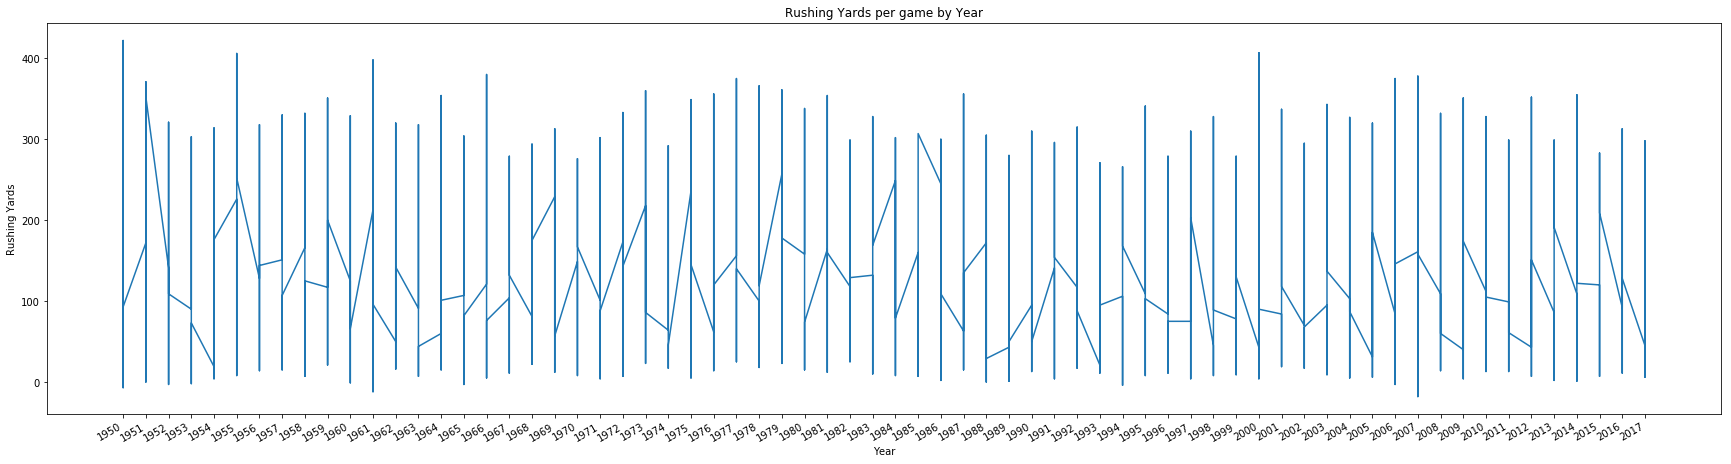

In [41]:
plt.plot(WinsWithRushStats['year'],WinsWithRushStats['rushing_yards'])
plt.xlabel("Year")
plt.ylabel("Rushing Yards")
plt.title("Rushing Yards per game by Year")
plt.gcf().autofmt_xdate()
plt.rcParams["figure.figsize"] = (30, 8)
plt.show()

The next two figures show the interceptions per game and the made field goals per game over the same time period. We can see that there is a slight decrease over time (since about 1965) of an overall trend for interceptions, even with the increase in pass attempts and pass yards over the years, which might be related to the objective of many teams to take care of the ball and not force unnecessary turnovers with risky passes. However, field goals made have increased as kicking abilities and importance of a strong kicking game has evolved.

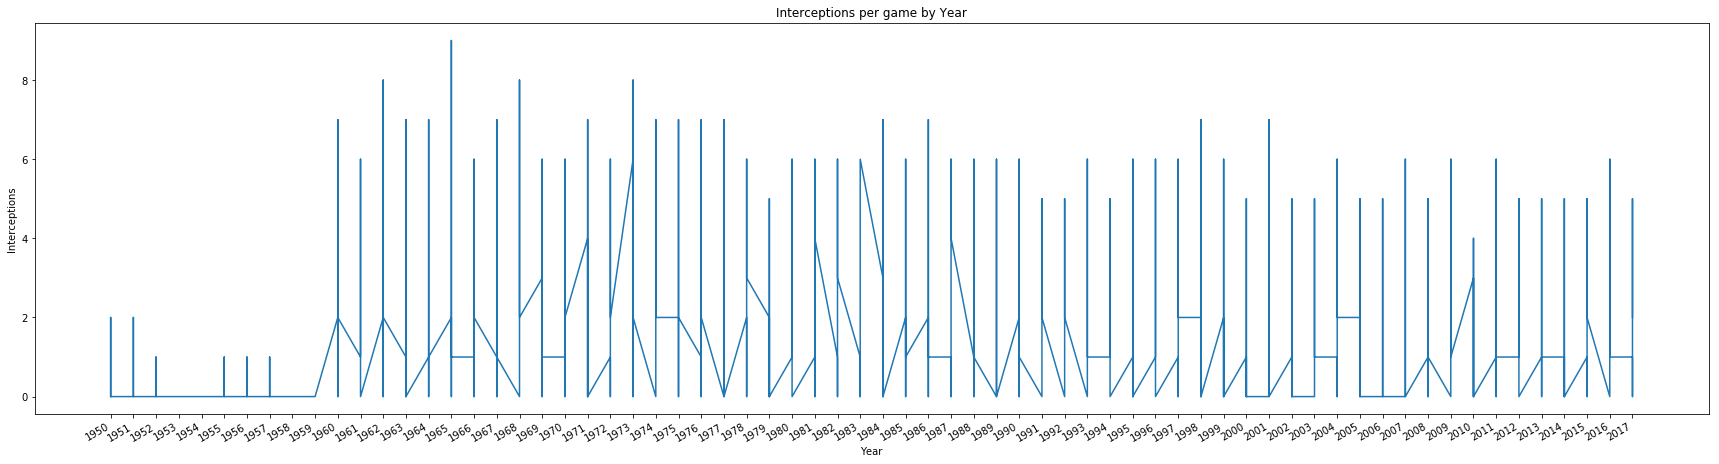

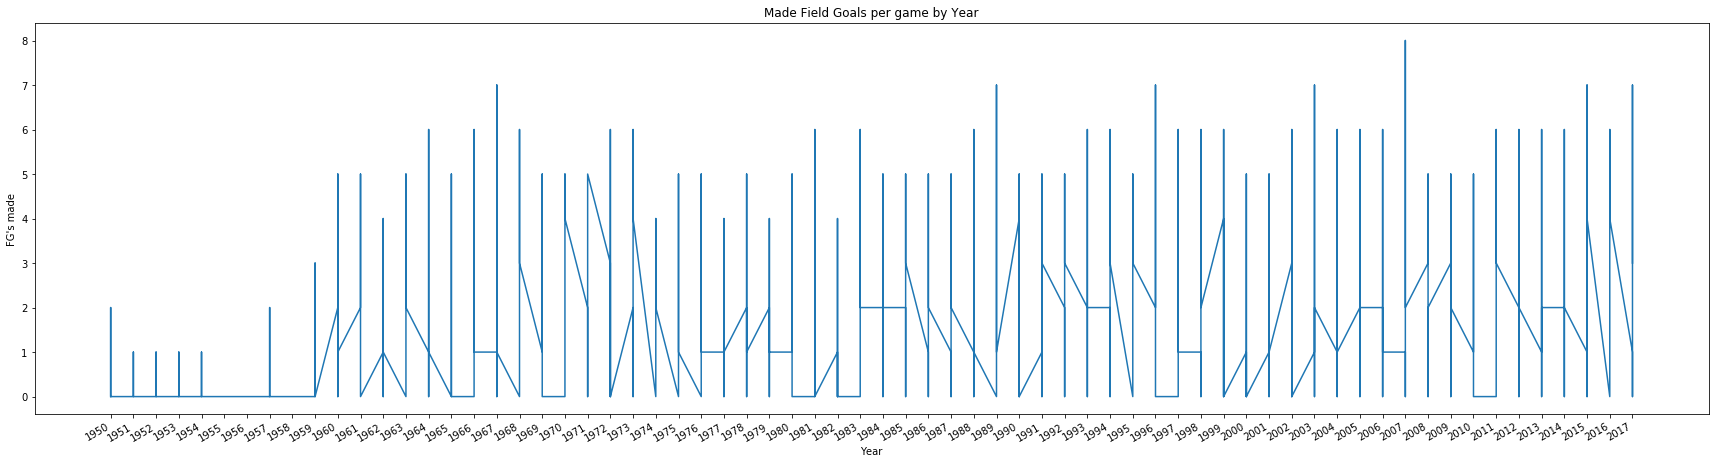

In [44]:
plt.plot(WinsWithDefense['year'],WinsWithDefense['defense_interceptions'])
plt.xlabel("Year")
plt.ylabel("Interceptions")
plt.title("Interceptions per game by Year")
plt.gcf().autofmt_xdate()
plt.show()

plt.plot(WinsWithSpecialTeams['year'],WinsWithSpecialTeams['field_goal_makes'])
plt.xlabel("Year")
plt.ylabel("FG's made")
plt.title("Made Field Goals per game by Year")
plt.gcf().autofmt_xdate()
plt.show()

Through logistic regression analysis we estimate the effect of various features of the most important 4 facets in the modern football era: Passing, Rushing, Defense and Special Teams. Here we find that the most significant predictor of winning is actually punt return touchdowns. This was unexpected as passing touchdowns are usually the more methodical apporach to scoring and success in the NFL. Passing touchdowns is the second most significant predictor. Being able to score thorugh the air (the quickest and most effecient method) should be the most beneficial aspect of football in terms of winning. We can interpret our figures as such: for every punt return touchdown scored by a team, their probability of winning increases by 15.9% & for every passing touchdown thrown by a team, they're probability of winning increases by 13.8%.

Rushing touchdowns, field goal makes and defensive interceptions are all also pronounced predictors of winning.

In [45]:
# Logistic Regressions

# instatiate x & y variables to regress
x_pass = WinsWithPassStats.iloc[:,3:-1]
y = WinsWithPassStats['game_won']
x_rush = WinsWithRushStats.iloc[:,3:-1]
x_defense = WinsWithDefense.iloc[:,3:-1]
x_special = WinsWithSpecialTeams.iloc[:,3:-1]

#logit regression
logit_pass = Logit(y, x_pass)
res_pass = logit_pass.fit(method='lbfgs')
logit_rush = Logit(y, x_rush)
res_rush = logit_rush.fit(method='lbfgs')
logit_defense = Logit(y, x_defense)
res_defense = logit_defense.fit(method='lbfgs')
logit_special = Logit(y, x_special)
res_special = logit_special.fit(method='lbfgs')

# marginal effects at the mean
me_pass = res_pass.get_margeff(at='mean').summary()
me_rush = res_rush.get_margeff(at='mean').summary()
me_defense = res_defense.get_margeff(at='mean').summary()
me_special = res_special.get_margeff(at='mean').summary()
print(me_pass)
print(me_rush)
print(me_defense)
print(me_special)

        Logit Marginal Effects       
Dep. Variable:               game_won
Method:                          dydx
At:                              mean
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
passing_attempts        0.0222      0.001     18.599      0.000       0.020       0.024
passing_completions    -0.0307      0.001    -48.125      0.000      -0.032      -0.029
passing_yards           0.0016   7.82e-05     20.231      0.000       0.001       0.002
passing_touchdowns      0.1378      0.004     36.487      0.000       0.130       0.145
        Logit Marginal Effects       
Dep. Variable:               game_won
Method:                          dydx
At:                              mean
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

In [47]:
# create train and test sets
x_train_pass = x_pass.iloc[:22000, :]
x_test_pass = x_pass.iloc[22000:, :]
x_train_rush = x_rush.iloc[:22000, :]
x_test_rush = x_rush.iloc[22000:, :]
x_train_defense = x_defense.iloc[:22000, :]
x_test_defense = x_defense.iloc[22000:, :]
x_train_special = x_special.iloc[:22000, :]
x_test_special = x_special.iloc[22000:, :]
y_train = y[:22000]
y_test = y[22000:]

In [48]:
# Predictions to win
clf_pass = LogisticRegression()
clf_pass.fit(x_train_pass, y_train)
clf_rush = LogisticRegression()
clf_rush.fit(x_train_rush, y_train)
clf_defense = LogisticRegression()
clf_defense.fit(x_train_defense, y_train)
clf_special = LogisticRegression()
clf_special.fit(x_train_special, y_train)
pass_predictions = clf_pass.predict(x_test_pass)
rush_predictions = clf_rush.predict(x_test_rush)
defense_predictions = clf_defense.predict(x_test_defense)
specialteams_predictions = clf_special.predict(x_test_special)

# Accuracy of predictions
print("Performance of Pass Predictions on Win Chance:",accuracy_score(y_test, pass_predictions))
print("Performance of Rush Predictions on Win Chance:",accuracy_score(y_test, rush_predictions))
print("Performance of Defense Predictions on Win Chance:",accuracy_score(y_test, defense_predictions))
print("Performance of Special Teams Predictions on Win Chance:",accuracy_score(y_test, specialteams_predictions))

Performance of Pass Predictions on Win Chance: 0.7234119782214156
Performance of Rush Predictions on Win Chance: 0.7154264972776769
Performance of Defense Predictions on Win Chance: 0.6983666061705989
Performance of Special Teams Predictions on Win Chance: 0.6112522686025408


/Users/Tyler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tyler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tyler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tyler/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [49]:
# Predict win chance from test set
prob_pass = clf_pass.predict_proba(x_test_pass)
prob_rush = clf_rush.predict_proba(x_test_rush)
prob_defense = clf_defense.predict_proba(x_test_defense)
prob_special = clf_special.predict_proba(x_test_special)

In [50]:
# append win chance %
pass_pred = x_test_pass.copy()
rush_pred = x_test_rush.copy()
defense_pred = x_test_defense.copy()
special_pred = x_test_special.copy()
pass_pred['win_chance'] = prob_pass[:,1]
rush_pred['win_chance'] = prob_rush[:,1]
defense_pred['win_chance'] = prob_defense[:,1]
special_pred['win_chance'] = prob_special[:,1]
pass_pred.head()

,passing_attempts,passing_completions,passing_yards,passing_touchdowns,win_chance
22000,16,26,187,3,0.828042
22001,18,23,173,3,0.917931
22002,19,35,236,2,0.447945
22003,29,38,286,3,0.786185
22004,28,45,369,3,0.514661


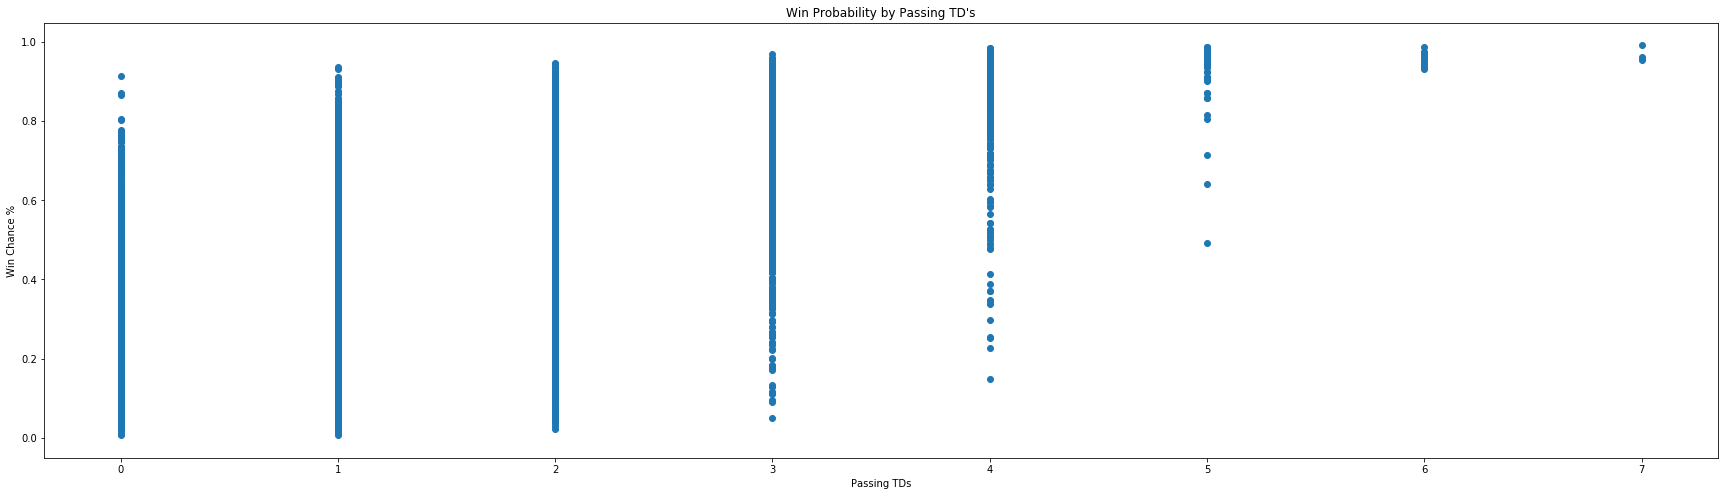

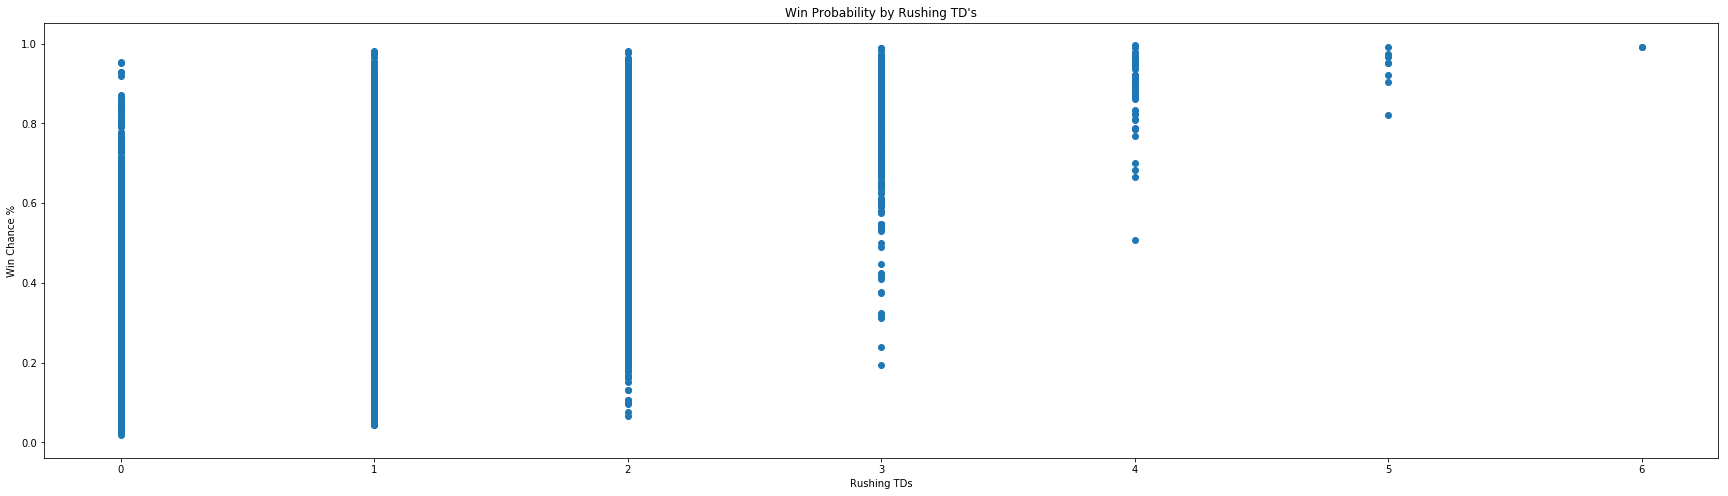

In [51]:
# Plots
plt.scatter(pass_pred['passing_touchdowns'],pass_pred['win_chance']) # Passing TD
plt.xlabel("Passing TDs")
plt.ylabel("Win Chance %")
plt.title("Win Probability by Passing TD's")
plt.show()

# Rushing TD
plt.scatter(rush_pred['rushing_touchdowns'],rush_pred['win_chance'])
plt.xlabel("Rushing TDs")
plt.ylabel("Win Chance %")
plt.title("Win Probability by Rushing TD's")
plt.show()

The above two plots show our predicted win percentage based on both passing and rushing touchdowns. We can see from the first figure that after about four touchdowns there is a significant increase in winning percentages. T When teams have at least 5 passing touchdowns, the win percentage jumps to above 80%. With passing touchdowns being more prevalent then rushing touchdowns, this occurs far more often than a team getting 5 rushing touchdowns. In comparison, we see a jump in predicted win percentage for rushing touchdowns after 4, which again is much more unlikely than 4 passing touchdowns. Prior to that, we dont see a major difference in the effect of rushing touchdowns on win percentage. These figures together show us why many more teams are shifting the focus of their offense to be centered around a strong quarterback and an efficient passing offense rather than a potent rushing attack.

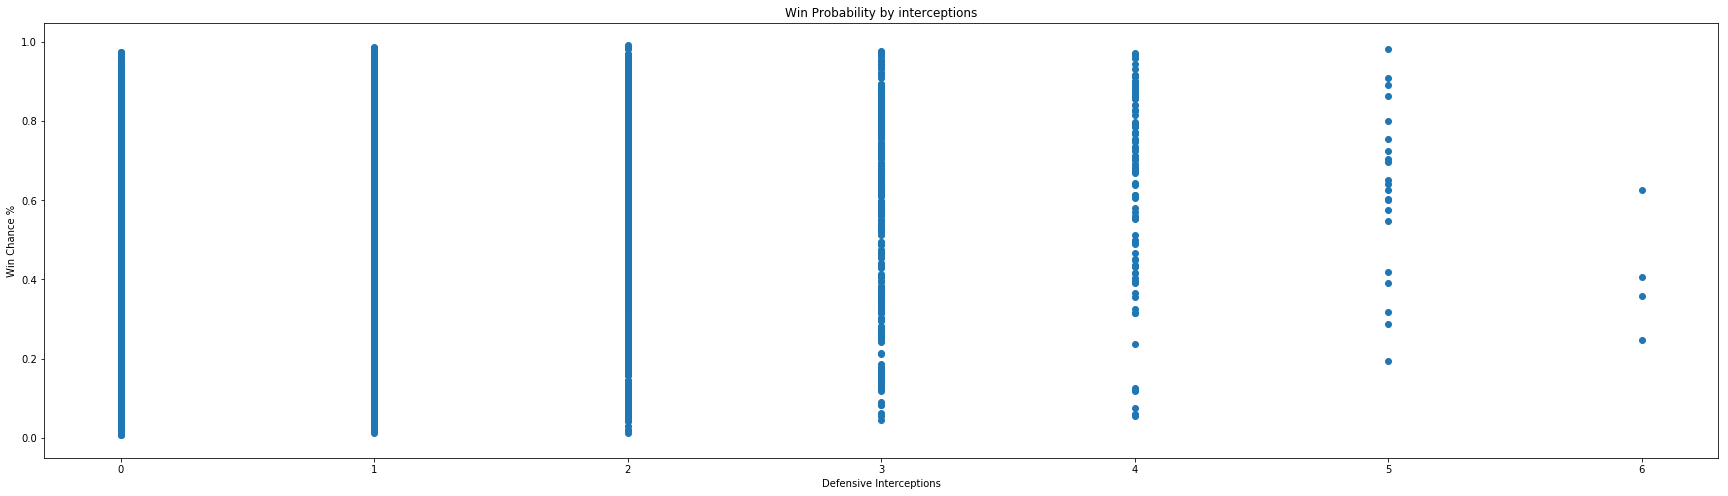

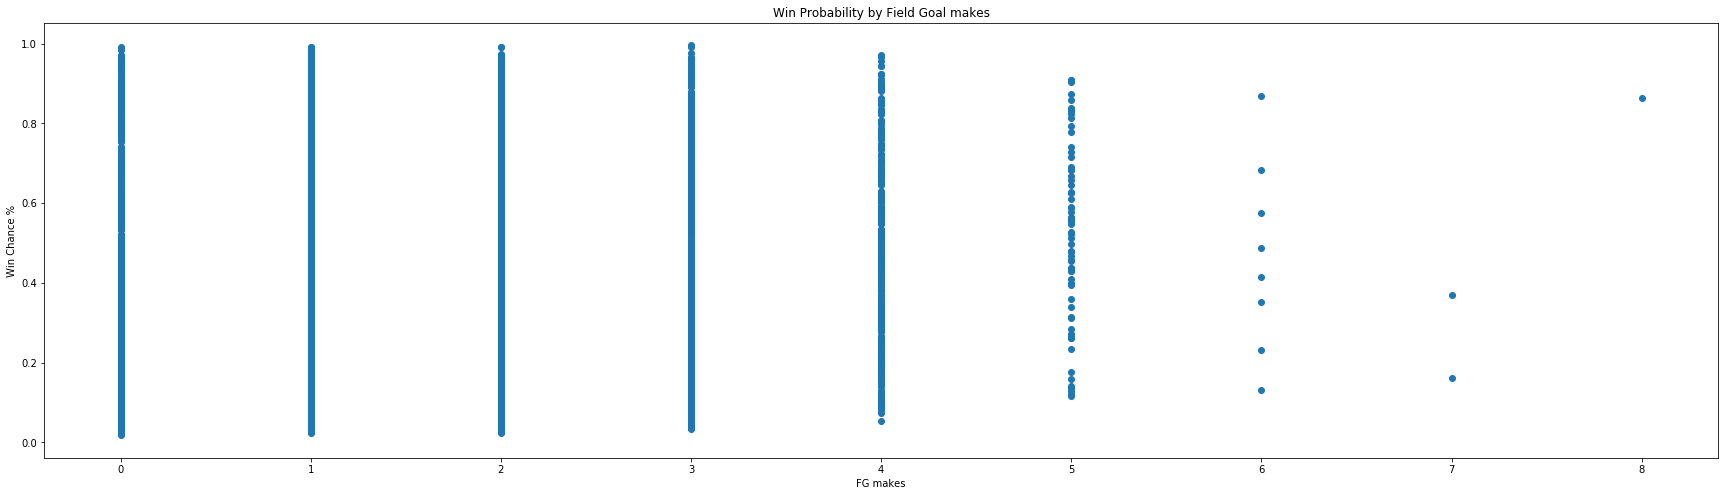

In [52]:
# Interceptions
plt.scatter(defense_pred['defense_interceptions'],pass_pred['win_chance']) # Passing TD
plt.xlabel("Defensive Interceptions")
plt.ylabel("Win Chance %")
plt.title("Win Probability by interceptions")
plt.show()

# FG made
plt.scatter(special_pred['field_goal_makes'],rush_pred['win_chance'])
plt.xlabel("FG makes")
plt.ylabel("Win Chance %")
plt.title("Win Probability by Field Goal makes")
plt.show()

The above two figures show the effects of both interceptions and made field goals on winning percentages in the NFL for a comparison. Unlike the previous figures which show the effects of rushing and passing touchdowns on winning percentages, we can see that there is a much smaller effect from both field goals and interceptions. With interceptions there are no real effects on winning percentage, which makes sense because of the rarity of interceptions throughout the season. A top tier quarterback in the NFL throws under 15 interceptions per season, which would be less than one per game. Often times these interceptions could come at non-pivotal points of the game, which is why their effect on winning percentage shows no true trend over time. Like interceptions, field goal makes have a much smaller effect on predicted winning percentage than rushing or passing touchdowns. This is of course affected by the fact that field goal makes only count for 3 points while touchdowns account for 6 (usually 7 with the extra point). As we expected, field goals have a much smaller effect on winning percentage overall.

### Conclusion:

Overall we can conclude from this play-by-play analysis that the most significant way to generate a greater win probability is to score punt return touchdowns. Also, passing touchdowns have a slightly larger effect in magnitude on a team's winning percentage compared to rushing touchdowns when you take into account the greater effenciency of passing touhdowns over rushing touchdowns, but scoring both will consdierably increase your chances of success. We can also see the effects of defensive performance in determining win percentage and interceptions and sacks influence the outcome unequivocally while special teams makes an even more notable impact with field goal makes and punt return touchdowns. Being able to score from unexpected souces provides a platform to win. We hypothesized before this analysis that teams should have a higher priority in their passing offense than to instead focus more on a running game. However, these results were more closely decisive in determining the chance to win than previously hypthoesized, but ultimately throwing touchdowns is more significant in impacting a team's chance to win than rushing for touchdowns. We also hypthosezied that interceptions would be greater influences on winning than other defensive and special team's plays, however punt return touchdowns and field goals made were better in predicting outcomes and more signficant.